In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
import keras.backend as K
print(tf.__version__)

# Create a list with the filepaths for training and testing
train_dir = Path('foodNonfood/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg')) + list(train_dir.glob(r'**/*.jpeg')) 

test_dir = Path('foodNonfood/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg')) + list(test_dir.glob(r'**/*.jpeg'))
val_dir = Path('foodNonfood/validation')
val_filepaths = list(val_dir.glob(r'**/*.jpg')) + list(test_dir.glob(r'**/*.jpeg')) 

def proc_img(filepath):
    """ Creating a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("\\")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

2.11.0


In [9]:
train_dir = Path('foodNonfood/train')
test_dir = Path('foodNonfood/test')
val_dir = Path('foodNonfood/validation')

# Preprocessing function
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = img / 255.0  # Normalize pixel values to [0, 1]
    return img

# Load and preprocess images for training set
train_images = np.array([preprocess_image(image_path) for image_path in train_df['Filepath']])
train_labels = np.array(train_df['Label'])

# Load and preprocess images for testing set
test_images = np.array([preprocess_image(image_path) for image_path in test_df['Filepath']])
test_labels = np.array(test_df['Label'])

# Load and preprocess images for validation set
val_images = np.array([preprocess_image(image_path) for image_path in val_df['Filepath']])
val_labels = np.array(val_df['Label'])

# Convert labels to binary format
train_labels = np.where(train_labels == 'food', 1, 0)
test_labels = np.where(test_labels == 'food', 1, 0)
val_labels = np.where(val_labels == 'food', 1, 0)

# Verify the shape of the data
print("Train Images shape:", train_images.shape)
print("Train Labels shape:", train_labels.shape)
print("Test Images shape:", test_images.shape)
print("Test Labels shape:", test_labels.shape)
print("Validation Images shape:", val_images.shape)
print("Validation Labels shape:", val_labels.shape)

Train Images shape: (3000, 224, 224, 3)
Train Labels shape: (3000,)
Test Images shape: (1000, 224, 224, 3)
Test Labels shape: (1000,)
Validation Images shape: (1000, 224, 224, 3)
Validation Labels shape: (1000,)


In [2]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 3000

Number of different labels: 2

Labels: ['food' 'non_food']


In [3]:
train_df.head(5)

,Filepath,Label
0,foodNonfood\train\food\2.jpg,food
1,foodNonfood\train\non_food\1173.jpg,non_food
2,foodNonfood\train\food\482.jpg,food
3,foodNonfood\train\food\708.jpg,food
4,foodNonfood\train\non_food\150.jpg,non_food


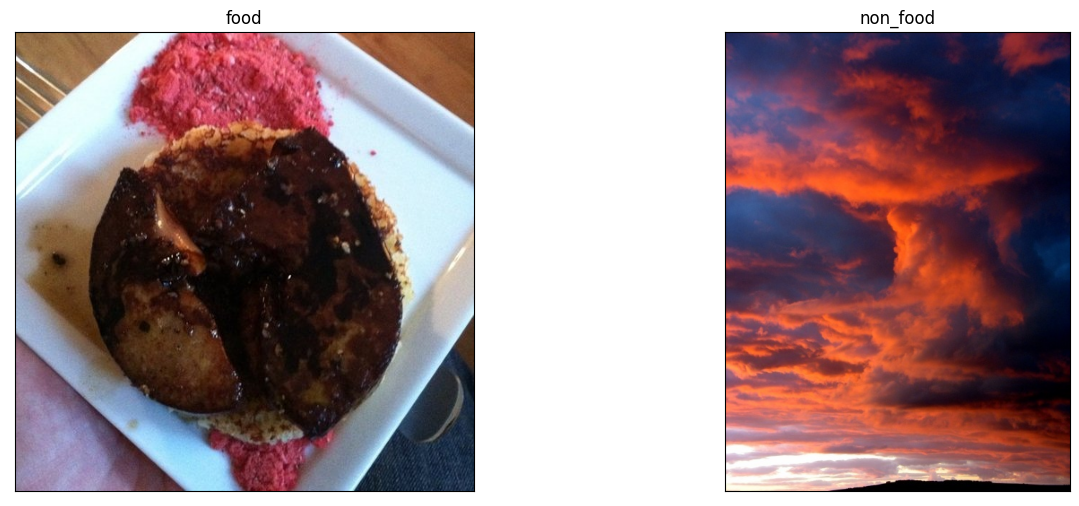

In [4]:
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [5]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 3000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


In [6]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [7]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    train_labels,  # assuming you have separate train_labels for binary classification
    validation_data=(val_images, val_labels),  # assuming you have separate val_labels for binary classification
    batch_size=32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)


NameError: name 'train_labels' is not defined

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
# Predict the Label of the testimages
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the Label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
y_test = [labels[k] for k in test_images.classes]
pred1[:10]

In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred1)
print(f'Accuracy on the test set: {100*acc:.2f}%')

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred1, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_test,
                            y_pred=pred1))